In [1]:
import numpy as np
import pymc as pm
import pandas as pd
import arviz as az
import matplotlib
import matplotlib.pyplot as plt
import os
import math
import pickle
import ast
import xarray as xr

In [2]:
with open("Data_A\\Ready_Synth_A.pkl", "rb") as f:
    data_dict = pickle.load(f)

In [3]:
cov_mat = data_dict['cov_mat']
grp_idx = data_dict['grp_idx']
obs_data = data_dict['obs_data']

In [4]:
coords = {
    'groups': ["left_bi","left_uni","right_bi","right_uni"],
    'betas': ["b0", "b1"],
    'trials': range(len(obs_data)) }

In [5]:
with pm.Model(coords=coords) as model_A:
    pm.MutableData("cov_mat", cov_mat, dims=("trials", "betas"))
    pm.MutableData("grp_idx", grp_idx, dims=("trials",))

    z_beta = pm.Normal("z_beta", mu = 0, sigma = 1, dims = ("betas", "groups"))
    beta_vec = pm.Deterministic("beta_vec", pm.math.stack([ 6 * z_beta[0] , 2 * z_beta[1] + 4 ], axis=0), dims = ("betas", "groups"))

    z_gam_h = pm.Beta("z_gam_h", mu = 0.2, sigma = 0.1, dims=("groups",) )
    gam_h = pm.Deterministic("gam_h", 0.25*z_gam_h, dims=("groups",) )
    z_gam_l = pm.Beta("z_gam_l", mu = 0.2, sigma = 0.1, dims=("groups",) )
    gam_l = pm.Deterministic("gam_l", 0.25*z_gam_l, dims=("groups",) )

    logistic_arg = pm.Deterministic(
        'logistic_arg',
        pm.math.sum(cov_mat * beta_vec[:, grp_idx].T, axis=1),
        dims=("trials",))

    p = pm.Deterministic(
        'p', 
        gam_h[grp_idx] + (1 - gam_h[grp_idx] - gam_l[grp_idx])*pm.math.invlogit(logistic_arg), 
        dims=("trials",))
    resp = pm.Bernoulli("resp", p=pm.math.clip(p,1e-8,1-1e-8), observed=obs_data, dims=('trials',))
    

In [6]:
print(model_A.debug())

point={'z_beta': array([[0., 0., 0., 0.],
       [0., 0., 0., 0.]]), 'z_gam_h_logodds__': array([-1.38629436, -1.38629436, -1.38629436, -1.38629436]), 'z_gam_l_logodds__': array([-1.38629436, -1.38629436, -1.38629436, -1.38629436])}

No problems found
None


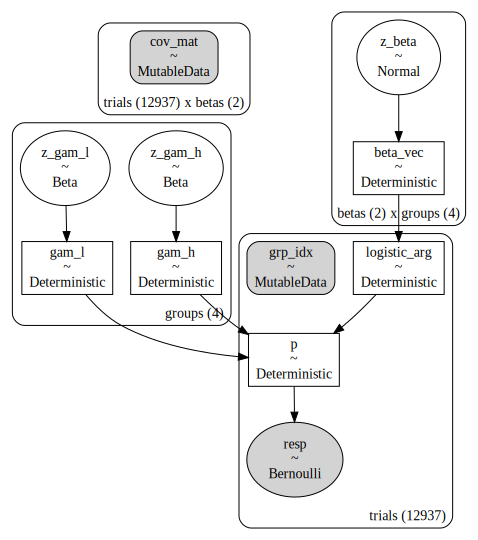

In [7]:
pm.model_to_graphviz(model_A)

Sampling: [resp, z_beta, z_gam_h, z_gam_l]


Text(0.5, 1.0, 'Prior predictive checks – group left_bi')

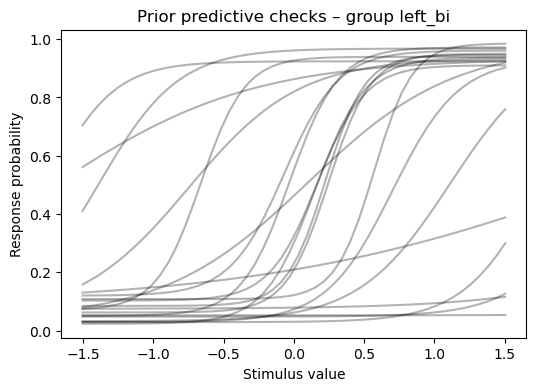

In [8]:
# PRIOR PREDICTIVE CHECKS
# Draw prior predictive samples
with model_A:
    idata_prior = pm.sample_prior_predictive(20)

prior = idata_prior.prior
prior_pred = idata_prior.prior_predictive

# Pick a group to visualize (e.g. "left_bi")
group_name = "left_bi"
group_idx = model_A.coords["groups"].index(group_name)

# Build a predictor grid
stim_grid = np.linspace(cov_mat[:,1].min(), cov_mat[:,1].max(), 50)  # the stimulus values
X_grid = np.column_stack([np.ones_like(stim_grid), stim_grid])

# Convert to xarray for nice broadcasting
stim_xr = xr.DataArray(stim_grid, dims=["plot_dim"])

# Extract priors for this group
beta = prior["beta_vec"].sel(betas="b1", groups=group_name)  # slope
intercept = prior["beta_vec"].sel(betas="b0", groups=group_name)
gam_h = prior["gam_h"].sel(groups=group_name)
gam_l = prior["gam_l"].sel(groups=group_name)

# Compute linear predictor for each draw
linpred = intercept + beta * stim_xr

# Pass through logistic link with lapse rates
p = gam_h + (1 - gam_h - gam_l) * 1/(1+np.exp(-linpred))

# Plot
fig, ax = plt.subplots(figsize=(6,4))
ax.plot(stim_grid, p.stack(sample=("chain","draw")), c="k", alpha=0.3)

ax.set_xlabel("Stimulus value")
ax.set_ylabel("Response probability")
ax.set_title(f"Prior predictive checks – group {group_name}")

In [9]:
with model_A:
    trace = pm.sample(return_inferencedata=True, cores=1, progressbar=True, idata_kwargs={"log_likelihood": True})   
print("FINISHED SAMPLING!")

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [z_beta, z_gam_h, z_gam_l]


 |█████████████| 100.00% [2000/2000 02:16<00:00 Sampling chain 1, 0 divergences]

Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 247 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


FINISHED SAMPLING!


In [10]:
az.summary(trace)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
"z_beta[b0, left_bi]",0.150,0.016,0.119,0.178,0.000,0.000,2011.0,1501.0,1.0
"z_beta[b0, left_uni]",-0.137,0.015,-0.166,-0.110,0.000,0.000,1821.0,1554.0,1.0
"z_beta[b0, right_bi]",0.213,0.027,0.166,0.267,0.001,0.001,1736.0,1491.0,1.0
"z_beta[b0, right_uni]",-0.162,0.025,-0.208,-0.116,0.001,0.001,1631.0,1432.0,1.0
"z_beta[b1, left_bi]",-0.439,0.108,-0.632,-0.217,0.002,0.002,1877.0,1359.0,1.0
...,...,...,...,...,...,...,...,...,...
p[12932],0.985,0.004,0.977,0.990,0.000,0.000,2739.0,1709.0,1.0
p[12933],0.057,0.007,0.046,0.070,0.000,0.000,2274.0,1788.0,1.0
p[12934],0.985,0.004,0.977,0.990,0.000,0.000,2739.0,1709.0,1.0
p[12935],0.945,0.008,0.930,0.959,0.000,0.000,2203.0,1298.0,1.0


In [16]:
param_samps = trace.posterior[['beta_vec', 'gam_h', 'gam_l']]

In [26]:
param_samps['gam_h']

<xarray.DataArray 'gam_h' (chain: 2, draw: 1000, groups: 4)> Size: 64kB
array([[[0.0657904 , 0.03349556, 0.02734008, 0.06505878],
        [0.06427459, 0.0242307 , 0.02623519, 0.07214013],
        [0.1012106 , 0.02886869, 0.0267211 , 0.05556653],
        ...,
        [0.10978007, 0.02143425, 0.04220588, 0.06111126],
        [0.06104997, 0.03177663, 0.03739353, 0.06187991],
        [0.08882634, 0.01183163, 0.0355423 , 0.06232375]],

       [[0.07694234, 0.02549136, 0.03844793, 0.05904257],
        [0.09207104, 0.01602737, 0.03565392, 0.0704757 ],
        [0.0645946 , 0.0145107 , 0.03986682, 0.05430319],
        ...,
        [0.08459124, 0.02915863, 0.02624269, 0.05303204],
        [0.0828686 , 0.01314292, 0.03110545, 0.06250864],
        [0.08541436, 0.03549287, 0.03487464, 0.04217157]]])
Coordinates:
  * chain    (chain) int32 8B 0 1
  * draw     (draw) int32 4kB 0 1 2 3 4 5 6 7 ... 993 994 995 996 997 998 999
  * groups   (groups) <U9 144B 'left_bi' 'left_uni' 'right_bi' 'right_uni'

In [34]:
gam_h_samps = {}
gam_l_samps = {}
beta_0_samps = {}
beta_1_samps = {}


for grp in ["left_bi","left_uni","right_bi","right_uni"]:
    gam_h_samps[grp] = param_samps['gam_h'].sel(groups = grp).values.flatten()
    gam_l_samps[grp] = param_samps['gam_l'].sel(groups = grp).values.flatten()
    beta_0_samps[grp] = param_samps['beta_vec'].sel(groups = grp, betas='b0').values.flatten()
    beta_1_samps[grp] = param_samps['beta_vec'].sel(groups = grp, betas='b1').values.flatten()

In [35]:
def psychfunc(params, X):
    """
    Psychometric function with lapses

    Parameters:
    params : [gamma, lambda_, beta0, beta1]
    X : Stimulus amplitude level

    Returns:
    probability of guess "high"

    """
    X = np.asarray(X)
    gam_h, gam_l, beta0, beta1 = params
    logistic = 1 / (1 + np.exp(-(beta0 + beta1 * X)))
    return gam_h + (1 - gam_h - gam_l) * logistic

C:\Users\schro\AppData\Local\Temp\ipykernel_7648\2905059291.py:18: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdis[grp] = az.hdi(y_samples[grp], hdi_prob=0.95)


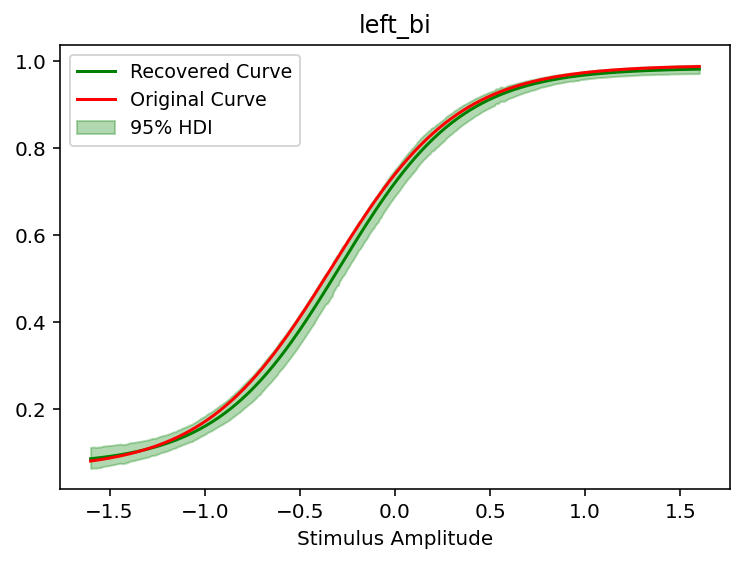

C:\Users\schro\AppData\Local\Temp\ipykernel_7648\2905059291.py:18: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdis[grp] = az.hdi(y_samples[grp], hdi_prob=0.95)


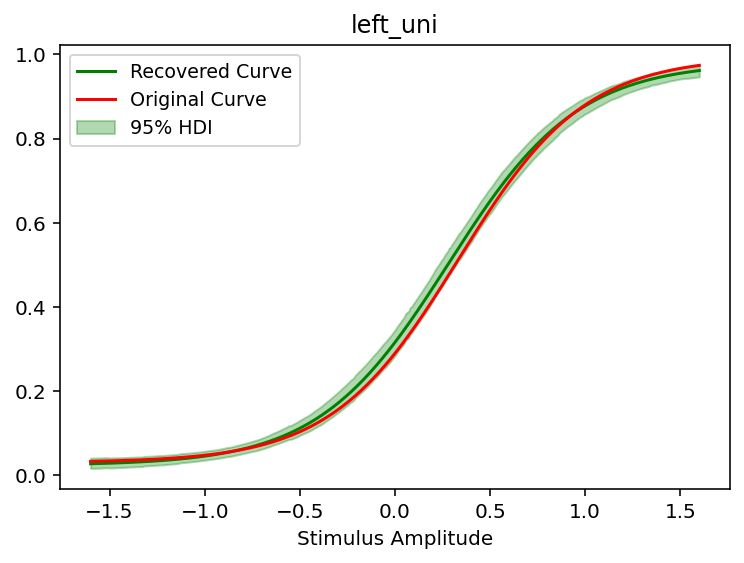

C:\Users\schro\AppData\Local\Temp\ipykernel_7648\2905059291.py:18: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdis[grp] = az.hdi(y_samples[grp], hdi_prob=0.95)


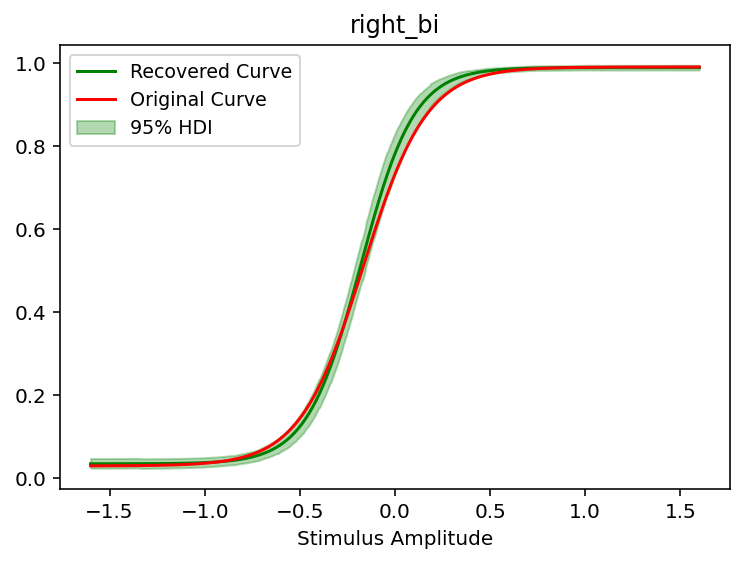

C:\Users\schro\AppData\Local\Temp\ipykernel_7648\2905059291.py:18: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdis[grp] = az.hdi(y_samples[grp], hdi_prob=0.95)


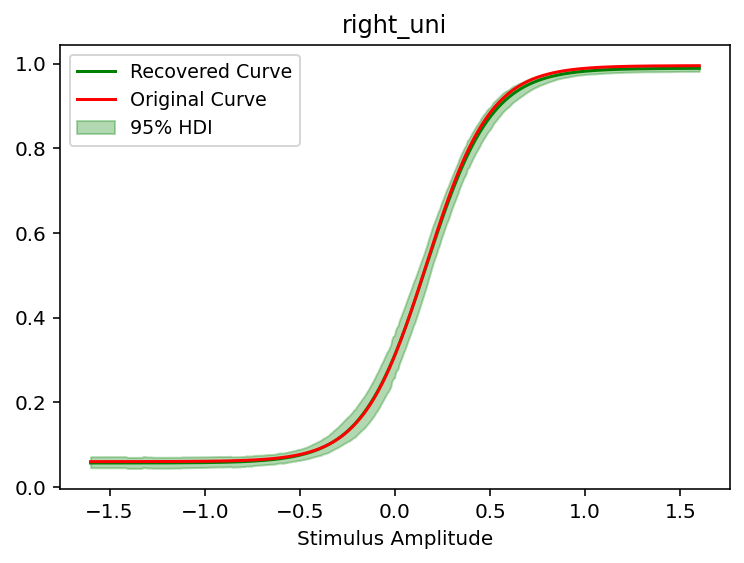

In [63]:
xfit = np.linspace(-1.6,1.6,500)
y_samples = {}
hdis = {}
rec_params = {}
yrec = {}
fixed = np.array([[0.03, 0.06, 0.06, 0.03],[0.005, 0.01, 0.005, 0.01],[-1, 1, -1, 1],[3, 3, 6, 6]])
fixed[:, [0, 1]] = fixed[:, [1, 0]]
fixed[:, [2, 3]] = fixed[:, [3, 2]]

for grp_i, grp in enumerate(["left_bi","left_uni","right_bi","right_uni"]):
    y_samples[grp] = np.array([psychfunc([gam_h,gam_l,beta_0,beta_1], xfit) 
                          for gam_h,gam_l,beta_0,beta_1 in zip(
                              gam_h_samps[grp], gam_l_samps[grp], beta_0_samps[grp], beta_1_samps[grp])])
    hdis[grp] = az.hdi(y_samples[grp], hdi_prob=0.95)
    rec_params[grp] = np.mean(np.array([gam_h_samps[grp], gam_l_samps[grp], beta_0_samps[grp], beta_1_samps[grp]]), axis = 1)
    
    
    yrec[grp] = psychfunc(rec_params[grp], xfit)
    
    plt.plot(xfit,yrec[grp],label='Recovered Curve',color='green')
    plt.plot(xfit, psychfunc(fixed[:,grp_i], xfit), label='Original Curve',color='red')
    plt.fill_between(xfit, hdis[grp][:, 0], hdis[grp][:, 1], color='green', alpha=0.3, label='95% HDI')
    #plt.scatter(x,ydata,label=f'Data: Total {int(nsum)} trials', color = 'red')
    plt.title(grp)
    plt.xlabel('Stimulus Amplitude')
    plt.legend(loc='upper left', fontsize=9.5)
    plt.show()   

In [93]:
with model_A:
    pm.sample_posterior_predictive(trace,extend_inferencedata=True)

█

Sampling: [resp]


 |████████████████████| 100.00% [2000/2000 00:02<00:00]

<Axes: xlabel='resp'>

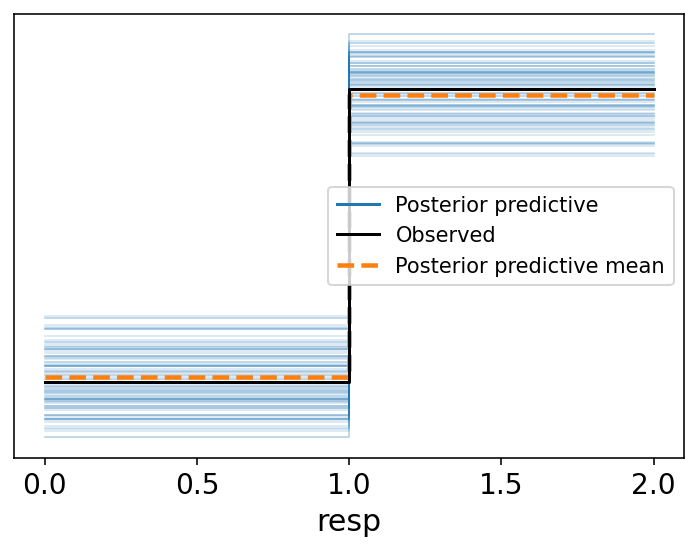

In [98]:
az.plot_ppc(trace, num_pp_samples=100)

In [99]:
trace.posterior_predictive

<xarray.Dataset> Size: 207MB
Dimensions:  (chain: 2, draw: 1000, trials: 12937)
Coordinates:
  * chain    (chain) int32 8B 0 1
  * draw     (draw) int32 4kB 0 1 2 3 4 5 6 7 ... 993 994 995 996 997 998 999
  * trials   (trials) int32 52kB 0 1 2 3 4 5 ... 12932 12933 12934 12935 12936
Data variables:
    resp     (chain, draw, trials) int64 207MB 1 1 1 0 0 0 0 1 ... 0 0 1 0 1 1 1
Attributes:
    created_at:                 2025-10-02T23:00:28.162142+00:00
    arviz_version:              0.21.0
    inference_library:          pymc
    inference_library_version:  5.3.0

In [79]:
squared_errors = (trace.posterior_predictive['resp'] - trace.observed_data['resp'])**2

In [82]:
pred_accuracy  = 1-np.mean(np.array(squared_errors))

In [89]:
naive_errors = ((cov_mat[:,1]>=0)- trace.observed_data['resp'])**2
naive_accuracy  = 1-np.mean(np.array(naive_errors))

In [106]:
np.mean(np.array(trace.posterior_predictive['resp']), axis= (0,1))

(12937,)

In [109]:
df = pd.DataFrame({
    "true_response": np.array(trace.observed_data['resp']),
    "pred_response_prob": np.mean(np.array(trace.posterior_predictive['resp']), axis= (0,1)),
    "stim": cov_mat[:,1],
    "group": grp_idx})

In [110]:
true_props = df.groupby(["stim", "group"])["true_response"].mean().reset_index()
pred_props = df.groupby(["stim", "group"])["pred_response_prob"].mean().reset_index()


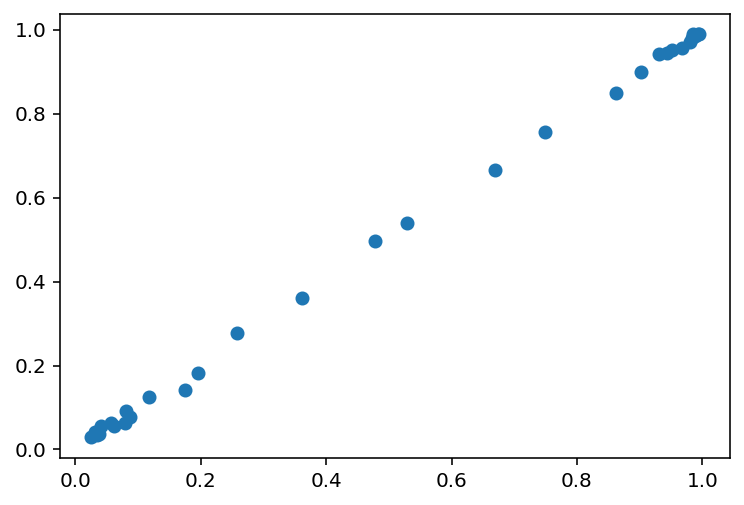

In [114]:
plt.scatter(true_props['true_response'], pred_props["pred_response_prob"])

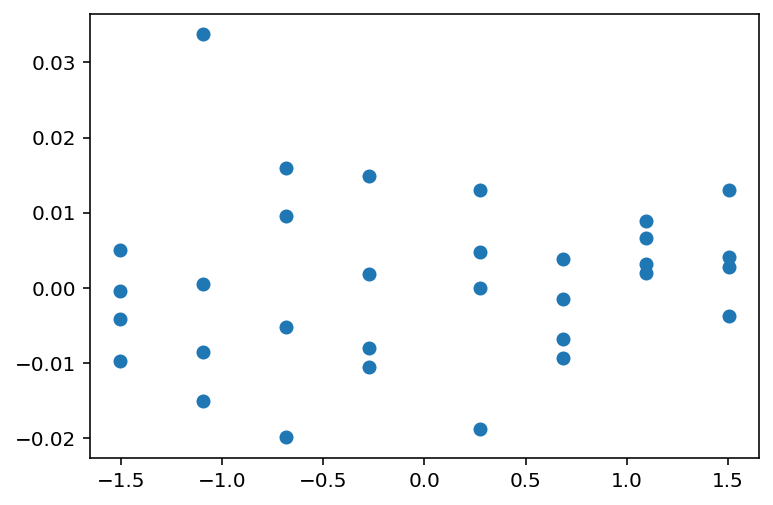

In [118]:
plt.scatter(true_props['stim'],true_props['true_response']- pred_props["pred_response_prob"])

In [122]:
np.corrcoef(abs(true_props['stim']),true_props['true_response']- pred_props["pred_response_prob"])[0,1]

0.09476917748418227

In [130]:
true_counts = np.array(df.groupby(["stim", "group"])["true_response"].sum().reset_index()["true_response"])
pred_counts = np.array(df.groupby(["stim", "group"])["pred_response_prob"].sum().reset_index()["pred_response_prob"])



In [137]:
df.groupby(["stim", "group"])["pred_response_prob"].mean()

stim       group
-1.503889  0        0.091452
           1        0.028706
           2        0.035269
           3        0.056806
-1.093737  0        0.141247
           1        0.040479
           2        0.036931
           3        0.056767
-0.683586  0        0.277425
           1        0.077572
           2        0.062014
           3        0.063496
-0.273434  0        0.538948
           1        0.181626
           2        0.360191
           3        0.124894
 0.273434  0        0.848754
           1        0.496545
           2        0.950865
           3        0.664343
 0.683586  0        0.940688
           1        0.756227
           2        0.986401
           3        0.944573
 1.093737  0        0.971278
           1        0.899477
           2        0.988454
           3        0.984454
 1.503889  0        0.979994
           1        0.954933
           2        0.988754
           3        0.988520
Name: pred_response_prob, dtype: float64

In [131]:
counts_error = pred_counts-true_counts
counts_error

array([ 3.9465e+00,  1.7120e+00,  1.7800e-01, -2.0505e+00, -1.3501e+01,
        3.4750e+00, -2.2750e-01,  6.1610e+00,  7.9700e+00, -3.8160e+00,
        2.1155e+00, -6.4110e+00,  4.2740e+00, -5.9865e+00, -7.6250e-01,
        3.2075e+00, -5.2545e+00,  7.6040e+00,  2.0000e-03, -1.9410e+00,
        3.8005e+00,  2.7595e+00, -1.5485e+00,  6.0750e-01, -3.5750e+00,
       -8.1250e-01, -2.6760e+00, -1.2805e+00, -1.1025e+00, -5.2520e+00,
        1.4905e+00, -1.6610e+00])

In [132]:
pred_counts

array([ 36.9465,  11.712 ,  14.178 ,  22.9495,  56.499 ,  16.475 ,
        14.7725,  23.161 , 110.97  ,  31.184 ,  25.1155,  25.589 ,
       218.274 ,  73.0135, 146.2375,  50.2075, 343.7455, 200.604 ,
       387.002 , 269.059 , 383.8005, 304.7595, 402.4515, 381.6075,
       391.425 , 365.1875, 400.324 , 397.7195, 396.8975, 386.748 ,
       396.4905, 401.339 ])

In [133]:
counts_error/pred_counts

array([ 1.06816613e-01,  1.46174863e-01,  1.25546622e-02, -8.93483518e-02,
       -2.38959982e-01,  2.10925645e-01, -1.54002369e-02,  2.66007513e-01,
        7.18212129e-02, -1.22370446e-01,  8.42308535e-02, -2.50537340e-01,
        1.95808937e-02, -8.19916865e-02, -5.21412087e-03,  6.38848778e-02,
       -1.52860183e-02,  3.79055253e-02,  5.16793195e-06, -7.21403112e-03,
        9.90227996e-03,  9.05468082e-03, -3.84766860e-03,  1.59194984e-03,
       -9.13329501e-03, -2.22488448e-03, -6.68458549e-03, -3.21960578e-03,
       -2.77779527e-03, -1.35799022e-02,  3.75923257e-03, -4.13864588e-03])

In [139]:
az.loo(trace)

Computed from 2000 posterior samples and 12937 observations log-likelihood matrix.

         Estimate       SE
elpd_loo -3724.63    66.81
p_loo       13.58        -
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.70]   (good)     12937  100.0%
   (0.70, 1]   (bad)          0    0.0%
   (1, Inf)   (very bad)     0    0.0%

In [144]:
predicted_probabilities = trace.posterior['p'].mean(dim=["chain", "draw"])

In [151]:
brier_score = np.mean(np.array((predicted_probabilities - np.array(trace.observed_data['resp']))**2))

print(f"The Brier score for the model is: {brier_score:.4f}")

The Brier score for the model is: 0.0853


In [152]:
bs_flat = np.mean((0.5 - np.array(trace.observed_data['resp']))**2)
bs_flat

0.25

In [153]:
bs_perf = np.mean(((cov_mat[:,1]>=0) - np.array(trace.observed_data['resp']))**2)
bs_perf

0.11888382159696993

In [154]:
brier_score

0.08527882234949224

In [155]:
BSS = 1- brier_score/bs_perf
BSS

0.2826709201980616

array([[<Axes: ylabel='gam_l\nleft_bi'>, <Axes: >, <Axes: >],
       [<Axes: ylabel='beta_vec\nb0, left_bi'>, <Axes: >, <Axes: >],
       [<Axes: xlabel='gam_h\nleft_bi', ylabel='beta_vec\nb1, left_bi'>,
        <Axes: xlabel='gam_l\nleft_bi'>,
        <Axes: xlabel='beta_vec\nb0, left_bi'>]], dtype=object)

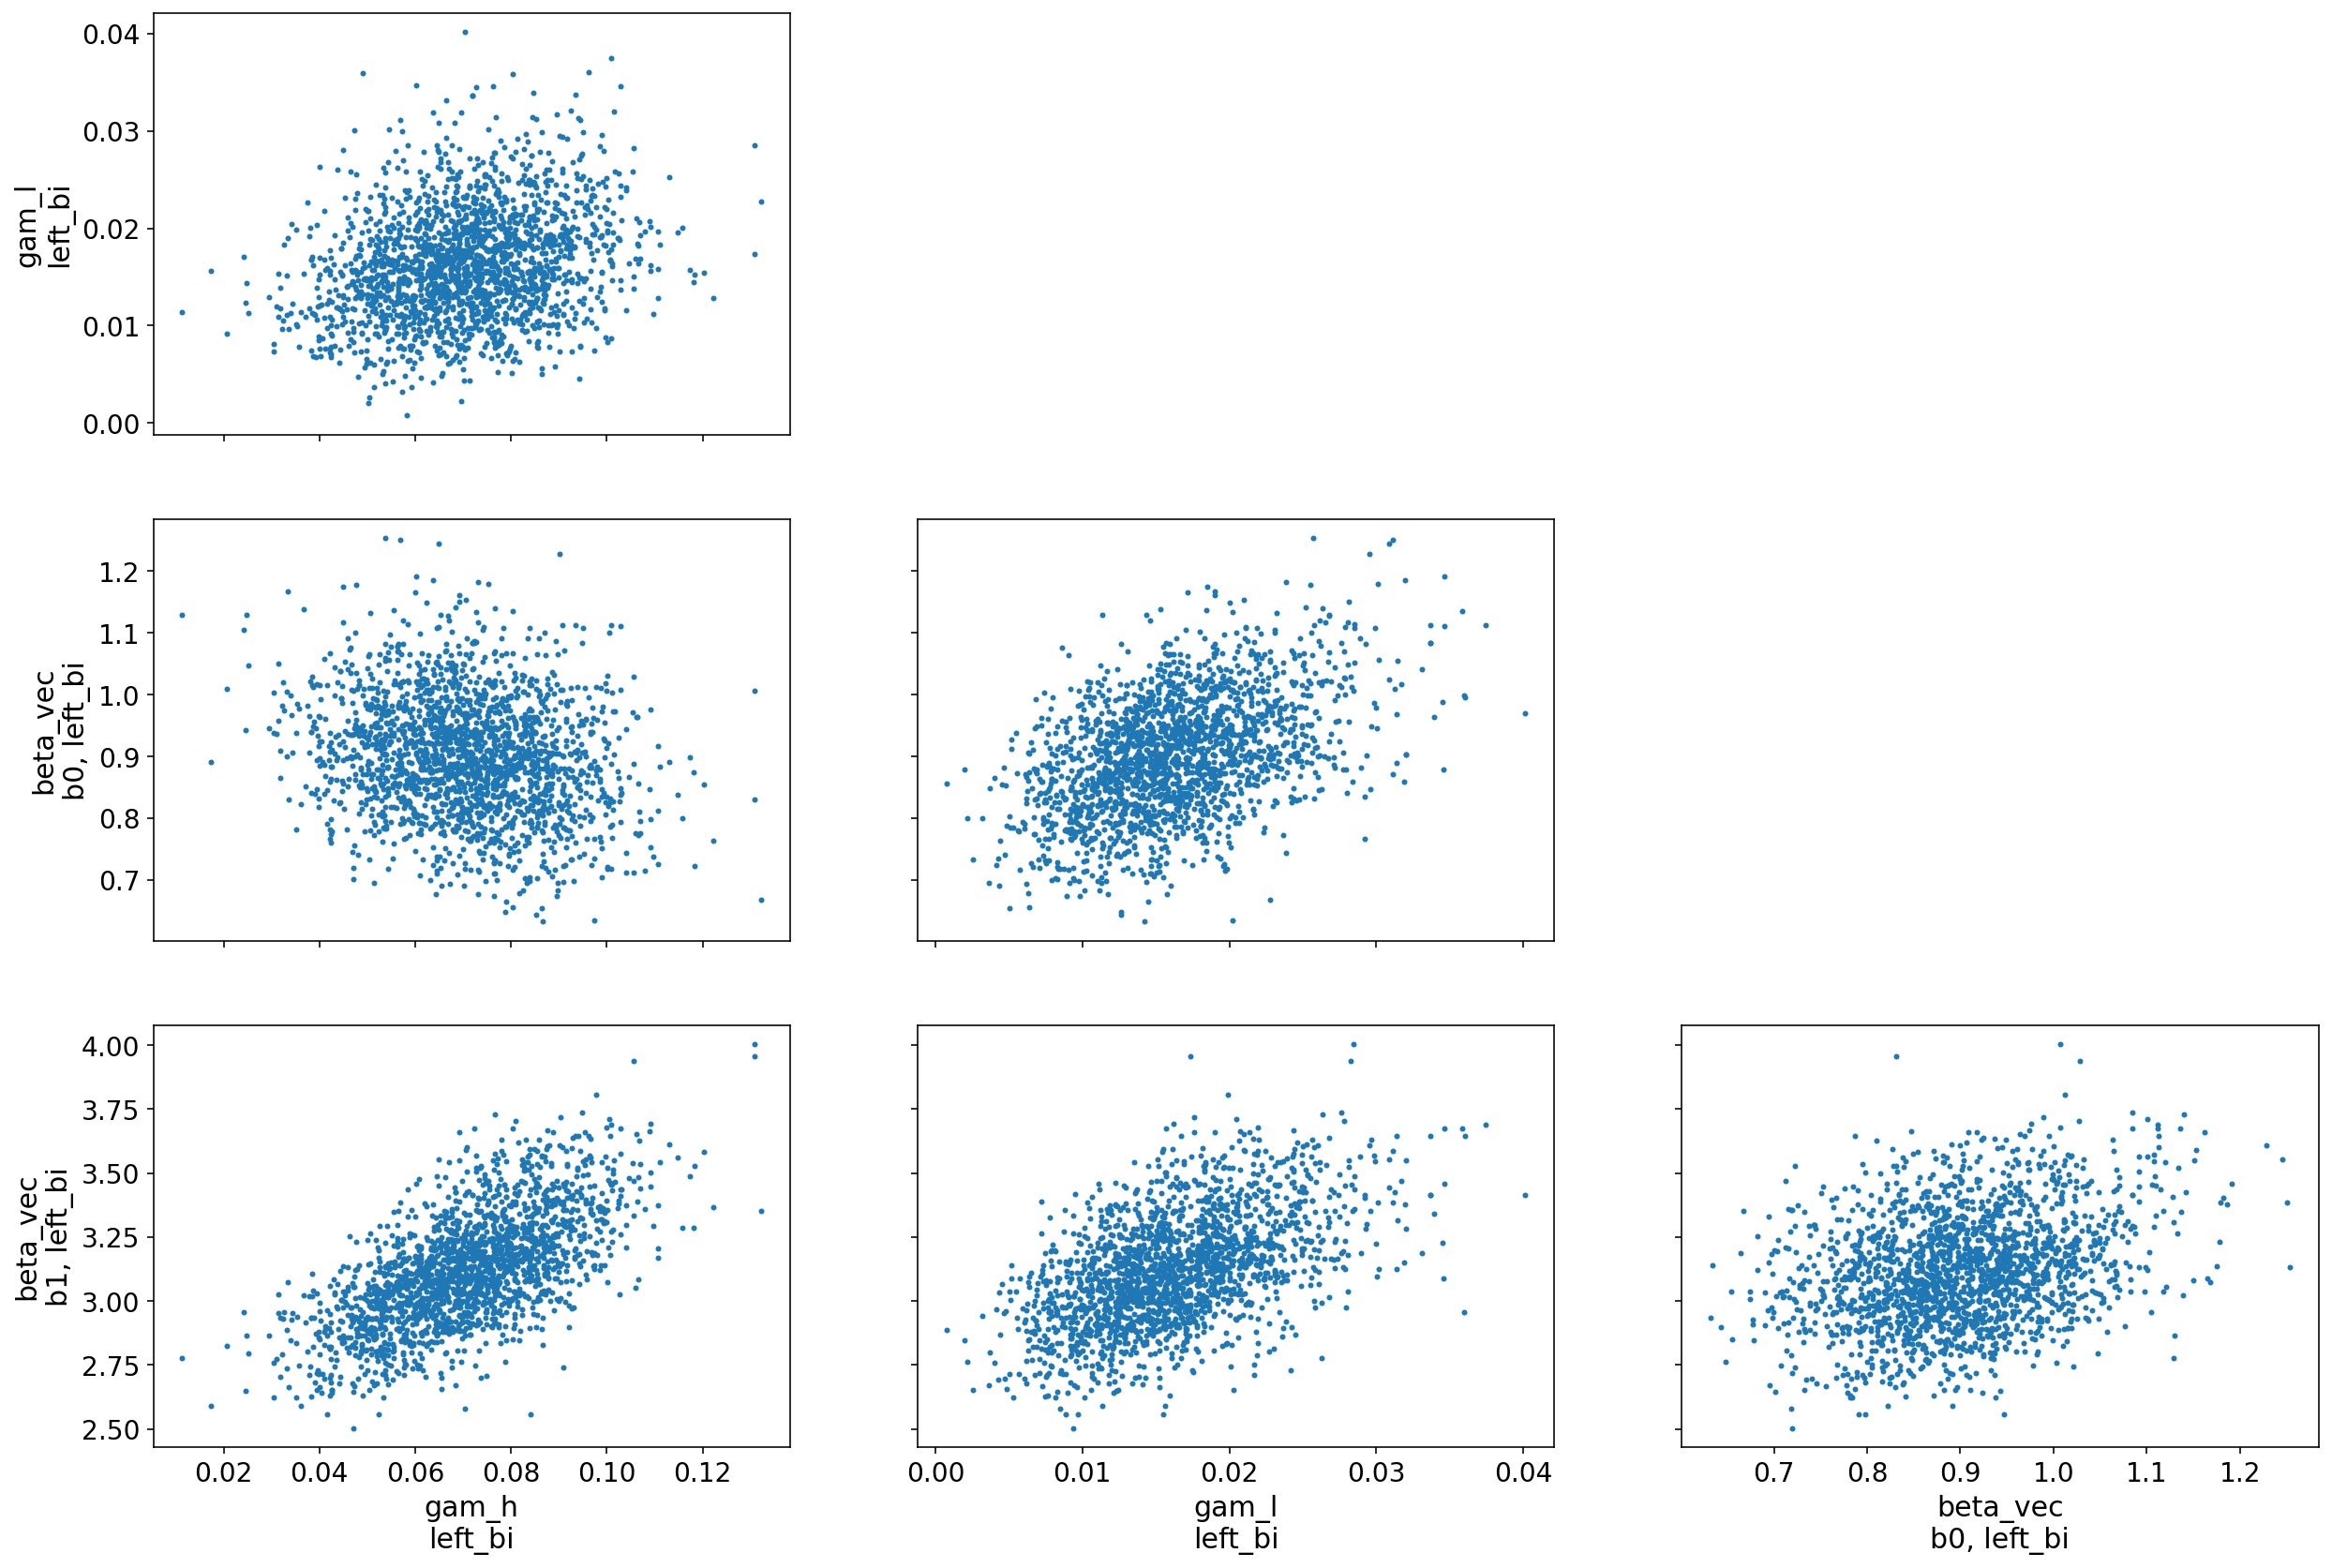

In [161]:
az.plot_pair(trace, var_names = ['gam_h','gam_l','beta_vec'], coords = {'groups': ["left_bi"], 'betas': ['b0','b1']})